In [2]:
import keras
import numpy as np
import pandas as pd
from PIL import Image
from keras.models import Model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, Flatten, Dense, Activation, MaxPooling2D, Dropout, Input, BatchNormalization
import imutils
import cv2

Using TensorFlow backend.


In [3]:
data = pd.read_csv('data/label.csv')

In [4]:
data.head()

,xRot,yRot,zRot
0,4,127,0
1,84,32,0
2,52,22,0
3,84,3,0
4,66,66,0


In [5]:
def preprocess(im):
    
    im = im/255
    im -= .5
    return im

In [6]:
channel = 1
im_size = 100
path = 'data/images_xy_arrow/'

In [23]:
def load_image_batch(ids, batch_size=32):
    
    image_batch = np.zeros((batch_size, im_size, im_size, channel))
    
    label_xRot = np.zeros((batch_size, 1))
    label_yRot = np.zeros((batch_size, 1))
    label_zRot = np.zeros((batch_size, 1))
    batch_ids = np.random.choice(ids, batch_size)
    
    ind = 0
    for i in range(len(batch_ids)):
        
        if channel == 1:
            im = Image.open(path + 'train_image_' + str(batch_ids[i]) + '.jpg').convert('L')
        else:
            im = Image.open(path + 'train_image_' + str(batch_ids[i]) + '.jpg')
        im = im.resize((im_size,im_size), Image.ANTIALIAS)
        im = np.array(im)
        image_batch[ind] = preprocess(im).reshape((im_size, im_size, channel))
        label_xRot[ind] = (data['xRot'][data.index==batch_ids[i]])/150
        label_yRot[ind] = (data['yRot'][data.index==batch_ids[i]])/150
        label_zRot[ind] = (data['zRot'][data.index==batch_ids[i]])/360
        ind += 1
            
    return (np.array(image_batch), np.array(label_xRot),np.array(label_yRot),np.array(label_zRot))

In [24]:
inp = Input(shape=(im_size,im_size, channel))

x = Conv2D(50, kernel_size=5, strides=2, activation='relu')(inp)
x = MaxPooling2D(pool_size=(2, 2), strides=2)(x)
x = BatchNormalization()(x)

x = Conv2D(100, kernel_size=3, strides=1, activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(150, kernel_size=3, strides=1, activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(200, kernel_size=3, strides=1, activation='relu')(x)
x = Dropout(.4)(x)

x = Flatten()(x)

xRot = Dense(100, activation='relu')(x)
xRot = Dense(200, activation='relu')(xRot)
xRot = Dense(1, activation='linear', name='xRot')(xRot)

yRot = Dense(100, activation='relu')(x)
yRot = Dense(200, activation='relu')(yRot)
yRot = Dense(1, activation='linear', name='yRot')(yRot)

zRot = Dense(100, activation='relu')(x)
zRot = Dense(200, activation='relu')(zRot)
zRot = Dense(1, activation='linear', name='zRot')(zRot)

model = Model(inputs=inp, outputs=[xRot, yRot, zRot])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 100, 100, 1)  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 48, 48, 50)   1300        input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 24, 24, 50)   0           conv2d_5[0][0]                   
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 24, 24, 50)   200         max_pooling2d_4[0][0]            
____________________________________________________________________________________________

In [25]:
learning_rate = [.001,.0005,.0001,.00005,.00001]
batch_size = [16,32,64,128,256]

train_ids = np.arange(10000)
test_ids = np.arange(500) + 9500
x_train, y1_train, y2_train, y3_train = load_image_batch(train_ids, 9500)

In [26]:
for i in range(len(learning_rate)):
    x_test, y1_test, y2_test, y3_test = load_image_batch(test_ids, 500)
    adam = keras.optimizers.adam(lr=learning_rate[i])
    model.compile(loss=['mse','mse','mse'], optimizer=adam, metrics=['accuracy', 'mae'])
    model.fit(x_train, [y1_train, y2_train, y3_train], epochs=2, batch_size=batch_size[i], validation_data=(x_test, [y1_test, y2_test, y3_test]))

Train on 9500 samples, validate on 500 samples
Epoch 1/2
9500/9500 [==============================] - 322s 34ms/step - loss: 0.1269 - xRot_loss: 0.0588 - yRot_loss: 0.0579 - zRot_loss: 0.0102 - xRot_accuracy: 0.0075 - xRot_mae: 0.1758 - yRot_accuracy: 0.0059 - yRot_mae: 0.1753 - zRot_accuracy: 0.9953 - zRot_mae: 0.0469 - val_loss: 0.0396 - val_xRot_loss: 0.0219 - val_yRot_loss: 0.0173 - val_zRot_loss: 1.0295e-04 - val_xRot_accuracy: 0.0060 - val_xRot_mae: 0.1087 - val_yRot_accuracy: 0.0100 - val_yRot_mae: 0.0995 - val_zRot_accuracy: 1.0000 - val_zRot_mae: 0.0076
Epoch 2/2
9500/9500 [==============================] - 311s 33ms/step - loss: 0.0251 - xRot_loss: 0.0120 - yRot_loss: 0.0128 - zRot_loss: 2.7988e-04 - xRot_accuracy: 0.0085 - xRot_mae: 0.0827 - yRot_accuracy: 0.0071 - yRot_mae: 0.0850 - zRot_accuracy: 1.0000 - zRot_mae: 0.0117 - val_loss: 0.0158 - val_xRot_loss: 0.0066 - val_yRot_loss: 0.0091 - val_zRot_loss: 2.2686e-05 - val_xRot_accuracy: 0.0060 - val_xRot_mae: 0.0639 - val_y

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-26-b387f91d65e8>", line 5, in <module>
    model.fit(x_train, [y1_train, y2_train, y3_train], epochs=2, batch_size=batch_size[i], validation_data=(x_test, [y1_test, y2_test, y3_test]))
  File "/opt/anaconda3/lib/python3.7/site-packages/keras/engine/training.py", line 1239, in fit
    validation_freq=validation_freq)
  File "/opt/anaconda3/lib/python3.7/site-packages/keras/engine/training_arrays.py", line 196, in fit_loop
    outs = fit_function(ins_batch)
  File "/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3740, in __call__
    outputs = self._graph_fn(*converted_inputs)
  File "/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/eager/function.py", line 1081, in __call__
    return self._call_impl(args, kwarg

KeyboardInterrupt: 

In [27]:
#model.save('xyRotModel') 

## Testing

In [7]:
#model = keras.models.load_model('clock.model')
model = keras.models.load_model('xyRotModel')

In [10]:
def predict(ind):
        
    im = Image.open(path + 'train_image_' + str(ind) + '.jpg')
    im = Image.open('yeey.jpg')
    plt.imshow(im)
    print('Input image:')
    plt.show()
    im = im.convert('L')
    im = im.resize((im_size,im_size), Image.ANTIALIAS)
    im = np.array(im)
    im = preprocess(im).reshape((1, im_size, im_size, channel))

    rot = model.predict(im)
    #im = Image.open('test.jpg')
    
    xRot = int(rot[0]*150)
    print('Detected x rotation:', str(xRot-75))
    print('Actual x rotation:',data['xRot'][ind]-75)
    print()
    
    yRot = int(rot[1]*150)
    print('Detected y rotation:', str(yRot-75))
    print('Actual y rotation:',data['yRot'][ind]-75)
    print()
    
    zRot = int(rot[2]*360)
    print('Detected Angle:', str(zRot))
    print('Actual Angle:',data['zRot'][ind])
    print()

Input image:


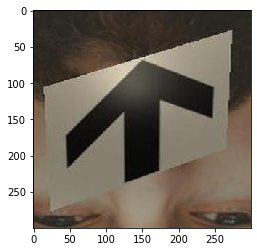

Detected x rotation: -36
Actual x rotation: -71

Detected y rotation: -48
Actual y rotation: 52

Detected Angle: 0
Actual Angle: 0

Input image:


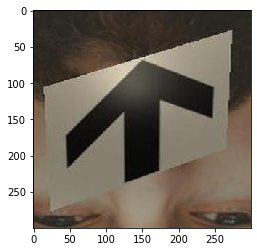

Detected x rotation: -36
Actual x rotation: 9

Detected y rotation: -48
Actual y rotation: -43

Detected Angle: 0
Actual Angle: 0

Input image:


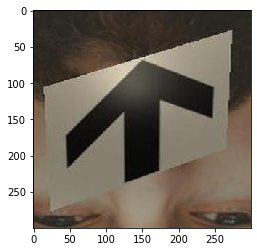

Detected x rotation: -36
Actual x rotation: -23

Detected y rotation: -48
Actual y rotation: -53

Detected Angle: 0
Actual Angle: 0

Input image:


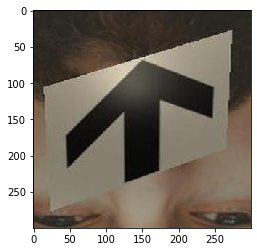

Detected x rotation: -36
Actual x rotation: 9

Detected y rotation: -48
Actual y rotation: -72

Detected Angle: 0
Actual Angle: 0

Input image:


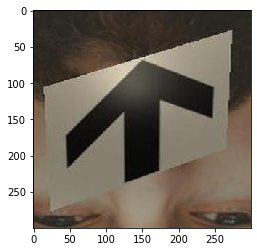

Detected x rotation: -36
Actual x rotation: -9

Detected y rotation: -48
Actual y rotation: -9

Detected Angle: 0
Actual Angle: 0

Input image:


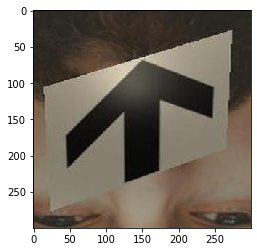

Detected x rotation: -36
Actual x rotation: -67

Detected y rotation: -48
Actual y rotation: -40

Detected Angle: 0
Actual Angle: 0

Input image:


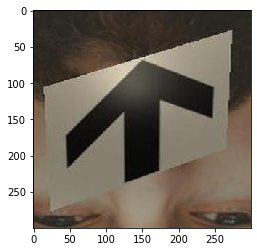

Detected x rotation: -36
Actual x rotation: 66

Detected y rotation: -48
Actual y rotation: 37

Detected Angle: 0
Actual Angle: 0

Input image:


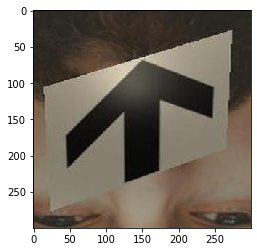

Detected x rotation: -36
Actual x rotation: -52

Detected y rotation: -48
Actual y rotation: 20

Detected Angle: 0
Actual Angle: 0

Input image:


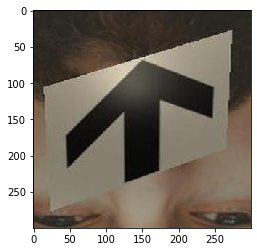

Detected x rotation: -36
Actual x rotation: 64

Detected y rotation: -48
Actual y rotation: 29

Detected Angle: 0
Actual Angle: 0

Input image:


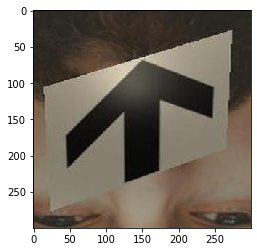

Detected x rotation: -36
Actual x rotation: -21

Detected y rotation: -48
Actual y rotation: 18

Detected Angle: 0
Actual Angle: 0



In [11]:
for i in range(10):
    predict(i)

Input image:


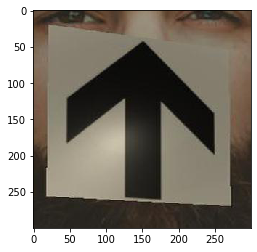

Detected Angle: 44
Actual Angle: 0



In [31]:
ind = 1
im = Image.open(path + 'train_image_'+str(ind)+'.jpg')
model_z = keras.models.load_model('zRotModel')
#im = Image.open('test.jpg')
plt.imshow(im)
print('Input image:')
plt.show()
im = im.convert('L')
im = im.resize((im_size,im_size), Image.ANTIALIAS)
im = np.array(im)
im = preprocess(im).reshape((1, im_size, im_size, channel))

rot_z = model_z.predict(im)
#im = Image.open('test.jpg')
#xRot = int(rot[0]*150)
#print('Detected x rotation:', str(xRot-75))
#print('Actual x rotation:',data['xRot'][ind]-75)
#print()

#yRot = int(rot[1]*150)
#print('Detected y rotation:', str(yRot-75))
#print('Actual y rotation:',data['yRot'][ind]-75)
#print()
    
zRot = int(rot_z[0]*360)
print('Detected Angle:', str(zRot))
print('Actual Angle:',data['zRot'][ind])
print()